# Stochastic, metapopulation, age-stratified SI2R

In this notebook we will present a model that partitions the population in four compartments: susceptibles, $S$, who can catch the disease; infected presymptomatic, $I^p$, that has caught the infection and are infectious but cannot be considered yet symptomatic nor asymptomatic;  asymptomatic infectives, $I^a$, who have already caught the disease and are infectives but do not present (nor will present) any symptoms of the infection; symptomatic infectives, $I^s$, who have already caught the disease and are infectives and symptomatic; and removed individuals, R. 

Since the epidemiological dynamics is much faster than the demographical one and there is no deaths considered in the model, the sum $N=S+I^p+I^a+I^s+R$ remains constant.

The ordinary differential equations of the SI3R model are (for each age group $i$):

\begin{align}
\dot S_i &= -\lambda(t)_i S_i \\
\dot I_i^p &= \lambda(t)_i S_i - \gamma_i^{I^p} I_i^p \\
\dot I_i^a &= \alpha_i \gamma_i^{I^p} I_i^p - \gamma_i^{I^a} I_i^a \\
\dot I_i^s &= \bar{\alpha_i} \gamma_i^{I^p} I_i^p - \gamma_i^{I^s} I_i^s \\
\dot R_i &= \gamma_i^{I^a} I_i^a + \gamma_i^{I^s} I_i^s
\end{align}

where:

* $\lambda(t)_i$ is the rate at which the suceptibles of age group $i$ get infected (full definition in the next cell)
* $\gamma_i^{I^x}$ is the rate of removal from one infected compartment $I^x$ to the next one (could be another infected or removed).
* $\alpha_i$ is the proportion of presymptomatic infected that become assymptomatic ones for the age group i ($\bar{\alpha_i} = 1 - \alpha_i$).

The rate at which the susceptibles get infected is 
$$
\lambda_i(t) = \beta \sum_{j=1}^M (C_{ij}^a \frac{I_j^p}{N_j} + C_{ij}^p \frac{I_j^a}{N_j} + C_{ij}^s \frac{I_j^s}{N_j})
$$
where the parameter $\beta$ is the probability of infection on contact. 

Let's start by considering the infected in all states and age groups are equally contagious ($C_{ij}^p = C_{ij}^a = C_{ij}^s  = C_{ij}$):

\begin{align}
\lambda_i(t) &= \beta \sum_{j=1}^M (C_{ij} \frac{I_j^p}{N_j} + C_{ij} \frac{I_j^a}{N_j} + C_{ij} \frac{I_j^s}{N_j})\\
\lambda_i(t) &= \beta \sum_{j=1}^M C_{ij} (\frac{I_j^p}{N_j} + \frac{I_j^a}{N_j} + \frac{I_j^s}{N_j})
\end{align}

Then, we consider that they contagiusness is constant over time we can obtain a much simpler expression:

$$
\lambda_i = \beta C_i \sum_{j=1}^M(\frac{I_j^p}{N_j} + \frac{I_j^a}{N_j} + \frac{I_j^s}{N_j})
$$

(Esto último tengo que ver bien como lo escribo, la idea es que no sean 200 mil parámetros)

In [22]:
%matplotlib inline
import pandas as pd
import numpy as np
import pyross
import time
import copy
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

## Model definition for one node

In [2]:
# Number of nodes in the metapopulation model
N_nodes = 1

# define basic compartments
classes = ["S", "Ip", "Ia", "Is", "R"]
model_spec_metapop = {"classes": []}

# create nodes
for node in range(0,N_nodes):
    for cl in classes:
        cl_node = cl + str(node)
        model_spec_metapop["classes"].append(cl_node)
        model_spec_metapop[cl_node] = {}

# populate terms
for node_i in range(0,N_nodes):
    # susceptibles
    clS_i = "S" + str(node_i)
    # infected presymptomatic
    clIp_i = "Ip" + str(node_i)
    gIpa_node_i = "alpha*gIp" + str(node_i)
    gIps_node_i = "(1-alpha)*gIp" + str(node_i)
    recovery_term_IpIa = [clIp_i, "-" + gIpa_node_i] 
    recovery_term_IpIs = [clIp_i, "-" + gIps_node_i]
    # infected asymptomatic
    clIa_i = "Ia" + str(node_i)
    gIa_node_i = "gIa" + str(node_i)
    recovery_term_IaIp = [clIp_i, gIpa_node_i]
    recovery_term_IaR = [clIa_i, "-" + gIa_node_i]
    # infected symptomatic
    clIs_i = "Is" + str(node_i)
    gIs_node_i = "gIs" + str(node_i)
    recovery_term_IsIp = [clIp_i, gIps_node_i]
    recovery_term_IsR = [clIs_i, "-" + gIs_node_i]
    # recovered
    clR_i = "R" + str(node_i)
    recovery_term_RIa = [clIa_i, gIa_node_i]
    recovery_term_RIs = [clIs_i, gIs_node_i]
    # force of infection terms
    force_of_infection_S = []
    force_of_infection_Ip = []
    for node_j in range(0,N_nodes):
        clIp_j = "Ip" + str(node_j)
        clIa_j = "Ia" + str(node_j)
        clIs_j = "Is" + str(node_j)
        beta_ij = "beta" + str(node_i) + str(node_j)
        force_of_infection_S.append([clIp_j, clS_i, "-" + beta_ij]) # Due to Ip
        force_of_infection_S.append([clIa_j, clS_i, "-" + beta_ij]) # Due to Ia
        force_of_infection_S.append([clIs_j, clS_i, "-" + beta_ij]) # Due to Is
        force_of_infection_Ip.append([clIp_j, clS_i, beta_ij])
        force_of_infection_Ip.append([clIa_j, clS_i, beta_ij])
        force_of_infection_Ip.append([clIs_j, clS_i, beta_ij])
    model_spec_metapop[clS_i]["infection"] = force_of_infection_S
    model_spec_metapop[clIp_i]["infection"] = force_of_infection_Ip
    # recovery terms
    model_spec_metapop[clIp_i]["linear"] = [recovery_term_IpIa, recovery_term_IpIs]
    model_spec_metapop[clIa_i]["linear"] = [recovery_term_IaIp, recovery_term_IaR]
    model_spec_metapop[clIs_i]["linear"] = [recovery_term_IsIp, recovery_term_IsR]
    model_spec_metapop[clR_i]["linear"]  = [recovery_term_RIa, recovery_term_RIs]

model_spec_metapop

{'classes': ['S0', 'Ip0', 'Ia0', 'Is0', 'R0'],
 'S0': {'infection': [['Ip0', 'S0', '-beta00'],
   ['Ia0', 'S0', '-beta00'],
   ['Is0', 'S0', '-beta00']]},
 'Ip0': {'infection': [['Ip0', 'S0', 'beta00'],
   ['Ia0', 'S0', 'beta00'],
   ['Is0', 'S0', 'beta00']],
  'linear': [['Ip0', '-alpha*gIp0'], ['Ip0', '-(1-alpha)*gIp0']]},
 'Ia0': {'linear': [['Ip0', 'alpha*gIp0'], ['Ia0', '-gIa0']]},
 'Is0': {'linear': [['Ip0', '(1-alpha)*gIp0'], ['Is0', '-gIs0']]},
 'R0': {'linear': [['Ia0', 'gIa0'], ['Is0', 'gIs0']]}}

In this reduced version of the model, the only parameters that we need to define are: $\beta$, $\gamma_i^{I^p}$, $\gamma_i^{I^{a,s}}$ y $\alpha$.

# Let's simulate and fit one node

Parameter definition (adding alpha to the linear terms $\gamma$ parameters):

In [3]:
# Only one node
alpha = 0.9

# Parameters for node 0
gIp0 = 0.15
gIa0 = gIp0
gIs0 = gIp0

# Contagiousness
beta00 = 0.9

parameters = {
    'alpha' : alpha,
    'gIp0' : gIp0,
    'beta00' : beta00,
}

def parameter_mapping(input_params, t):
    output_params = {
        'alpha' : input_params['alpha'],
        'gIp0' : input_params['gIp0'],
        'alpha*gIp0' : input_params['alpha']*input_params['gIp0'],
        '(1-alpha)*gIp0' : (1 - input_params['alpha'])*input_params['gIp0'],
        'gIa0': input_params['gIp0'],
        'gIs0': input_params['gIp0'],
        'beta00' : input_params['beta00'],
    }
    return output_params


parameters

{'alpha': 0.9, 'gIp0': 0.15, 'beta00': 0.9}

In [4]:
parameter_mapping(parameters,1)

{'alpha': 0.9,
 'gIp0': 0.15,
 'alpha*gIp0': 0.135,
 '(1-alpha)*gIp0': 0.014999999999999996,
 'gIa0': 0.15,
 'gIs0': 0.15,
 'beta00': 0.9}

In [5]:
# Age groups
M = 1
# Number of people in node i, age-stratified
N0 = np.array([3000.0])
N1 = np.array([3000.0])
pop_distribution = np.array([N0]) # node x age
N_age = pop_distribution.sum(axis=0)
N = np.sum(N_age)

# Initial conditions in node 0
Ip0_ini = [15.0]
Ia0_ini = [0.0]
Is0_ini = [0.0]
S0_ini = (N0 - Ip0_ini - Ia0_ini - Is0_ini).tolist()
R0_ini = [0.0]

# Initial conditions in node 1
Ip1_ini = [0.0]
Ia1_ini = [0.0]
Is1_ini = [0.0]
S1_ini = (N1 - Ip1_ini - Ia1_ini - Is1_ini).tolist()
R1_ini = [0.0]

x0 = {
    'S0': S0_ini,
    'Ip0': Ip0_ini,
    'Ia0': Ia0_ini,
    'Is0': Is0_ini,
    'R0': R0_ini,
}

# age contact matrix
CM = np.array([
    [1, 1],
    [1, 1]
], dtype=float)

def contactMatrix(t):
    return CM

x0

{'S0': [2985.0], 'Ip0': [15.0], 'Ia0': [0.0], 'Is0': [0.0], 'R0': [0.0]}

## Synthetic data

Run model:

In [6]:
# duration of simulation and data file
N_start = 0
Tf = 99
Nf = Tf + 1

# model instantiation
# note that Model class doesn't accept 'parameter_mapping' keyword argument but 'time_dep_param_mapping'
model = pyross.stochastic.Model(model_spec_metapop, parameters, M, N_age, time_dep_param_mapping=parameter_mapping)

# simulate model
data = model.simulate(x0, contactMatrix, Tf, Nf)

In [7]:
# save synthetic data
data_array = data['X'].astype('float')
x = data_array.copy()
x = x[N_start:N_start+Nf]
print(x[0].astype('int'))

[2985   15    0    0    0]


Plot synthetic data:

In [8]:
# Get the data
S0 = np.sum(model.model_class_data('S0', data), axis=1)
Ip0 = np.sum(model.model_class_data('Ip0', data), axis=1)
Ia0 = np.sum(model.model_class_data('Ia0', data), axis=1)
Is0 = np.sum(model.model_class_data('Is0', data), axis=1)
R0 = np.sum(model.model_class_data('R0', data), axis=1)
t = data['t']

Text(0.5, 0, 'Days')

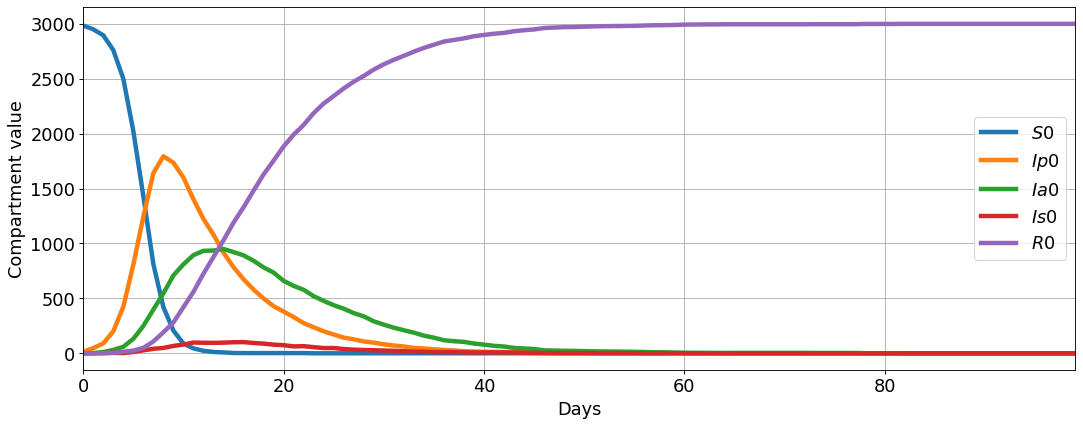

In [9]:
# Plot the data: separate nodes
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 16})
if N_nodes == 1:
    ax1 = fig.subplots(1,1)
else:
    ax1, ax2 = fig.subplots(1,2)

ax1.plot(t, S0, '-',  label='$S0$', lw=4)
ax1.plot(t, Ip0, '-', label='$Ip0$', lw=4)
ax1.plot(t, Ia0, '-', label='$Ia0$', lw=4)
ax1.plot(t, Is0, '-', label='$Is0$', lw=4)
ax1.plot(t, R0, '-',  label='$R0$', lw=4)
ax1.legend()
ax1.grid()
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('Compartment value')
ax1.set_xlabel('Days')

## Inference from synthetic one-node data

Let's use the first 20 days to infer the rest of the dynamics.

In [12]:
Tf_inference = 20
Nf_inference = Tf_inference + 1

# initialise the estimator 
estimator = pyross.inference.Model(model_spec_metapop, parameters, M, N_age, steps=4, time_dep_param_mapping=parameter_mapping)

In [13]:
# Active cases
fltr = np.kron([[0, 0, 0, 1, 0]],np.identity(M)) # Only the infected symptomatic
obs=np.einsum('ij,kj->ki', fltr, x[N_start:N_start+Nf_inference]) # DON'T LET obs BE LONGER THAN THE INFERENCE INTERVAL
print(estimator.class_index_dict.keys())
print(fltr)
print(obs.shape)

dict_keys(['S0', 'Ip0', 'Ia0', 'Is0', 'R0'])
[[0. 0. 0. 1. 0.]]
(21, 1)


In [14]:
# compute -log_p for the original (correct) parameters 
start_time = time.time()
x0 = x[0]

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp)
print(end_time - start_time)

54.9621781762983
0.04744410514831543


#### Priors

In [15]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
alpha_g, gIp0_g, beta00_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'gIp0':{
        'mean': gIp0_g,
        'std': 0.1*gIp0_g,
        'bounds': [0*gIp0_g, 4*gIp0_g],
        'prior_fun': 'truncnorm'
    },
    'beta00':{
        'mean': beta00_g,
        'std': 0.1*beta00_g,
        'bounds': [0*beta00_g, 4*beta00_g],
        'prior_fun': 'truncnorm'
    }
}

# make initial value guesses and set up bounds for each initial value
S_bounds = [4000, 8000]
I_bounds = [eps, 20]
init_fltr = np.repeat([True, True, True, False, True], M) # AT LEAST ONE OF THE OBSERVED MUST BE SET TO FALSE (should all of them be False?)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        'mean': [3000, 15, eps, eps],
        'std': [100, 10, 1, 1],
        'bounds': [[2800, 3000], [0, 30], [0, 2], [0, 2]]
    }
}

print(estimator.class_index_dict.keys())
print(init_priors)

dict_keys(['S0', 'Ip0', 'Ia0', 'Is0', 'R0'])
{'independent': {'fltr': array([ True,  True,  True, False,  True]), 'mean': [3000, 15, 0.0001, 0.0001], 'std': [100, 10, 1, 1], 'bounds': [[2800, 3000], [0, 30], [0, 2], [0, 2]]}}


#### Actual fitting

In [17]:
# optimisation parameters 
ftol = 1e-8 # the relative tol in (-logp)  

estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods 
start_time = time.time()
res = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=100, global_atol=0.1, 
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=100)
end_time = time.time()
print(end_time - start_time)

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=1318450623, Fri Oct 28 15:09:12 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 7.730759201647325e+01 1.0e+00 1.12e+00  2e-02  9e+01 0:00.2
    2     32 7.993867549518491e+01 1.6e+00 1.17e+00  2e-02  1e+02 0:00.4
    3     48 7.387999532452170e+01 1.7e+00 1.07e+00  1e-02  8e+01 0:00.6
   18    288 6.440924939221583e+01 2.8e+00 5.57e-01  7e-03  4e+01 0:03.6
   39    624 4.200135208522600e+01 1.5e+01 1.95e-01  3e-03  1e+01 0:07.7
   64   1024 3.341697038607681e+01 1.5e+02 5.95e-02  5e-04  4e+00 0:12.8
   95   1520 1.679683374721937e+01 4.5e+03 3.27e-02  1e-05  5e+00 0:18.9
  100   1600 1.828710141097111e+01 7.9e+03 3.03e-02  8e-06  5e+00 0:19.9
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  12.86480517539205
Starting local minimisation...
Local optimisation: Maximum number of iterations reached.
Optimal valu

In [23]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates = res['params_dict'].copy()
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print((x[0]).astype('int'))


map_x0 = res['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0.astype('int'))

logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_inference, contactMatrix)

print('\n log p for best estimates:')
print(logp)

True parameters
{'alpha': 0.9, 'gIp0': 0.15, 'beta00': 0.9}

 Best estimates
{'alpha': 0.9, 'gIp0': 0.17039116300287532, 'beta00': 0.8209619696441153}

 True initial conditions: 
[2985   15    0    0    0]

 Inferred initial conditions: 
[2955   19    0    0    0]

 log p for best estimates:
54.85250085309142


#### Plot

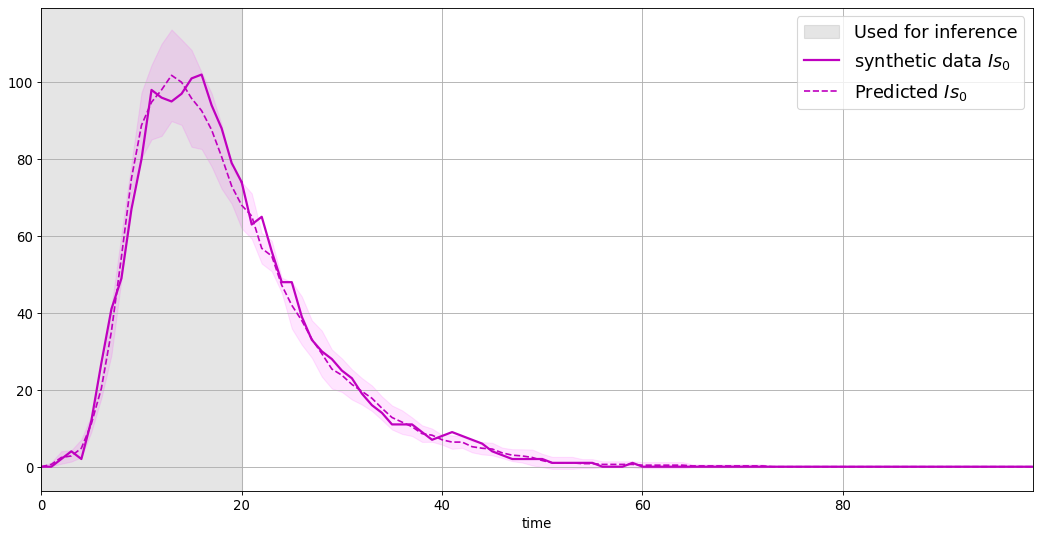

In [26]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
ax1 = fig1.subplots(1,1)

x_start = map_x0
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], Is0[:N_start+Tf_inference+1], 'm-', label='synthetic data $Is_0$', lw=2)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], Is0[N_start+Tf_inference:], 'm-', lw=2)

# show stochastic variability
N_runs = 5
Is0_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec_metapop, best_estimates, M, N_age, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    Is0_fit[loop] = np.sum(model_fit.model_class_data('Is0',data_fit), axis=1)

Is0_fit_mean = np.mean(Is0_fit,axis=0)
Is0_fit_std = np.std(Is0_fit,axis=0)

plt.plot(t, Is0_fit_mean, 'm--',label='Predicted $Is_0$')
plt.fill_between(t,Is0_fit_mean-Is0_fit_std,Is0_fit_mean+Is0_fit_std,color='magenta', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

# Now let's simulate and fit two nodes

In [27]:
# Number of nodes in the metapopulation model
N_nodes = 2

# define basic compartments
classes = ["S", "Ip", "Ia", "Is", "R"]
model_spec_metapop = {"classes": []}

# create nodes
for node in range(0,N_nodes):
    for cl in classes:
        cl_node = cl + str(node)
        model_spec_metapop["classes"].append(cl_node)
        model_spec_metapop[cl_node] = {}

# populate terms
for node_i in range(0,N_nodes):
    # susceptibles
    clS_i = "S" + str(node_i)
    # infected presymptomatic
    clIp_i = "Ip" + str(node_i)
    gIpa_node_i = "alpha*gIp" + str(node_i)
    gIps_node_i = "(1-alpha)*gIp" + str(node_i)
    recovery_term_IpIa = [clIp_i, "-" + gIpa_node_i] 
    recovery_term_IpIs = [clIp_i, "-" + gIps_node_i]
    # infected asymptomatic
    clIa_i = "Ia" + str(node_i)
    gIa_node_i = "gIa" + str(node_i)
    recovery_term_IaIp = [clIp_i, gIpa_node_i]
    recovery_term_IaR = [clIa_i, "-" + gIa_node_i]
    # infected symptomatic
    clIs_i = "Is" + str(node_i)
    gIs_node_i = "gIs" + str(node_i)
    recovery_term_IsIp = [clIp_i, gIps_node_i]
    recovery_term_IsR = [clIs_i, "-" + gIs_node_i]
    # recovered
    clR_i = "R" + str(node_i)
    recovery_term_RIa = [clIa_i, gIa_node_i]
    recovery_term_RIs = [clIs_i, gIs_node_i]
    # force of infection terms
    force_of_infection_S = []
    force_of_infection_Ip = []
    for node_j in range(0,N_nodes):
        clIp_j = "Ip" + str(node_j)
        clIa_j = "Ia" + str(node_j)
        clIs_j = "Is" + str(node_j)
        beta_ij = "beta" + str(node_i) + str(node_j)
        force_of_infection_S.append([clIp_j, clS_i, "-" + beta_ij]) # Due to Ip
        force_of_infection_S.append([clIa_j, clS_i, "-" + beta_ij]) # Due to Ia
        force_of_infection_S.append([clIs_j, clS_i, "-" + beta_ij]) # Due to Is
        force_of_infection_Ip.append([clIp_j, clS_i, beta_ij])
        force_of_infection_Ip.append([clIa_j, clS_i, beta_ij])
        force_of_infection_Ip.append([clIs_j, clS_i, beta_ij])
    model_spec_metapop[clS_i]["infection"] = force_of_infection_S
    model_spec_metapop[clIp_i]["infection"] = force_of_infection_Ip
    # recovery terms
    model_spec_metapop[clIp_i]["linear"] = [recovery_term_IpIa, recovery_term_IpIs]
    model_spec_metapop[clIa_i]["linear"] = [recovery_term_IaIp, recovery_term_IaR]
    model_spec_metapop[clIs_i]["linear"] = [recovery_term_IsIp, recovery_term_IsR]
    model_spec_metapop[clR_i]["linear"]  = [recovery_term_RIa, recovery_term_RIs]

model_spec_metapop

{'classes': ['S0', 'Ip0', 'Ia0', 'Is0', 'R0', 'S1', 'Ip1', 'Ia1', 'Is1', 'R1'],
 'S0': {'infection': [['Ip0', 'S0', '-beta00'],
   ['Ia0', 'S0', '-beta00'],
   ['Is0', 'S0', '-beta00'],
   ['Ip1', 'S0', '-beta01'],
   ['Ia1', 'S0', '-beta01'],
   ['Is1', 'S0', '-beta01']]},
 'Ip0': {'infection': [['Ip0', 'S0', 'beta00'],
   ['Ia0', 'S0', 'beta00'],
   ['Is0', 'S0', 'beta00'],
   ['Ip1', 'S0', 'beta01'],
   ['Ia1', 'S0', 'beta01'],
   ['Is1', 'S0', 'beta01']],
  'linear': [['Ip0', '-alpha*gIp0'], ['Ip0', '-(1-alpha)*gIp0']]},
 'Ia0': {'linear': [['Ip0', 'alpha*gIp0'], ['Ia0', '-gIa0']]},
 'Is0': {'linear': [['Ip0', '(1-alpha)*gIp0'], ['Is0', '-gIs0']]},
 'R0': {'linear': [['Ia0', 'gIa0'], ['Is0', 'gIs0']]},
 'S1': {'infection': [['Ip0', 'S1', '-beta10'],
   ['Ia0', 'S1', '-beta10'],
   ['Is0', 'S1', '-beta10'],
   ['Ip1', 'S1', '-beta11'],
   ['Ia1', 'S1', '-beta11'],
   ['Is1', 'S1', '-beta11']]},
 'Ip1': {'infection': [['Ip0', 'S1', 'beta10'],
   ['Ia0', 'S1', 'beta10'],
   ['Is0', 'S

In [28]:
alpha = 0.9

# Parameters for node 0
gIp0 = 0.15
gIa0 = gIp0
gIs0 = gIp0

# Parameters for node 1
gIp1 = 0.3
gIa1 = gIp1
gIs1 = gIp1

# Contagiousness
beta00 = 0.9
beta01 = 0.1
beta10 = 0.05
beta11 = 0.6

parameters = {
    'alpha' : alpha,
    'gIp0' : gIp0,
    'gIp1' : gIp1,
    'beta00' : beta00,
    'beta01' : beta01,
    'beta10' : beta10,
    'beta11' : beta11
}

def parameter_mapping(input_params, t):
    output_params = {
        'alpha' : input_params['alpha'],
        'gIp0' : input_params['gIp0'],
        'alpha*gIp0' : input_params['alpha']*input_params['gIp0'],
        '(1-alpha)*gIp0' : (1 - input_params['alpha'])*input_params['gIp0'],
        'gIa0': input_params['gIp0'],
        'gIs0': input_params['gIp0'],
        'gIp1' : input_params['gIp1'],
        'alpha*gIp1' : input_params['alpha']*input_params['gIp1'],
        '(1-alpha)*gIp1' : (1 - input_params['alpha'])*input_params['gIp1'],
        'gIa1': input_params['gIp1'],
        'gIs1': input_params['gIp1'],
        'beta00' : input_params['beta00'],
        'beta01' : input_params['beta01'],
        'beta10' : input_params['beta01'], # symmetric contagiousness!!
        'beta11' : input_params['beta11']
    }
    return output_params


parameters

{'alpha': 0.9,
 'gIp0': 0.15,
 'gIp1': 0.3,
 'beta00': 0.9,
 'beta01': 0.1,
 'beta10': 0.05,
 'beta11': 0.6}

In [29]:
parameter_mapping(parameters,1)

{'alpha': 0.9,
 'gIp0': 0.15,
 'alpha*gIp0': 0.135,
 '(1-alpha)*gIp0': 0.014999999999999996,
 'gIa0': 0.15,
 'gIs0': 0.15,
 'gIp1': 0.3,
 'alpha*gIp1': 0.27,
 '(1-alpha)*gIp1': 0.029999999999999992,
 'gIa1': 0.3,
 'gIs1': 0.3,
 'beta00': 0.9,
 'beta01': 0.1,
 'beta10': 0.1,
 'beta11': 0.6}

In [30]:
# Age groups
M = 1
# Number of people in node i, age-stratified
N0 = np.array([3000.0])
N1 = np.array([3000.0])
pop_distribution = np.array([N0]) # node x age
N_age = pop_distribution.sum(axis=0)
N = np.sum(N_age)

# Initial conditions in node 0
Ip0_ini = [15.0]
Ia0_ini = [0.0]
Is0_ini = [0.0]
S0_ini = (N0 - Ip0_ini - Ia0_ini - Is0_ini).tolist()
R0_ini = [0.0]

# Initial conditions in node 1
Ip1_ini = [10.0]
Ia1_ini = [0.0]
Is1_ini = [0.0]
S1_ini = (N1 - Ip1_ini - Ia1_ini - Is1_ini).tolist()
R1_ini = [0.0]

x0 = {
    'S0': S0_ini,
    'Ip0': Ip0_ini,
    'Ia0': Ia0_ini,
    'Is0': Is0_ini,
    'R0': R0_ini,
    'S1': S1_ini,
    'Ip1': Ip1_ini,
    'Ia1': Ia1_ini,
    'Is1': Is1_ini,
    'R1': R1_ini
}

# age contact matrix
CM = np.array([
    [1, 1],
    [1, 1]
], dtype=float)

def contactMatrix(t):
    return CM

x0

{'S0': [2985.0],
 'Ip0': [15.0],
 'Ia0': [0.0],
 'Is0': [0.0],
 'R0': [0.0],
 'S1': [2990.0],
 'Ip1': [10.0],
 'Ia1': [0.0],
 'Is1': [0.0],
 'R1': [0.0]}

## Synthetic data

Run model:

In [31]:
# duration of simulation and data file
N_start = 0
Tf = 99
Nf = Tf + 1

# model instantiation
# note that Model class doesn't accept 'parameter_mapping' keyword argument but 'time_dep_param_mapping'
model = pyross.stochastic.Model(model_spec_metapop, parameters, M, N_age, time_dep_param_mapping=parameter_mapping)

# simulate model
data = model.simulate(x0, contactMatrix, Tf, Nf)

In [32]:
# save synthetic data
data_array = data['X'].astype('float')
x = data_array.copy()
x = x[N_start:N_start+Nf]
print(x[0].astype('int'))

[2985   15    0    0    0 2990   10    0    0    0]


Plot synthetic data:

In [33]:
# Get the data
S0 = np.sum(model.model_class_data('S0', data), axis=1)
Ip0 = np.sum(model.model_class_data('Ip0', data), axis=1)
Ia0 = np.sum(model.model_class_data('Ia0', data), axis=1)
Is0 = np.sum(model.model_class_data('Is0', data), axis=1)
R0 = np.sum(model.model_class_data('R0', data), axis=1)
if N_nodes > 1:
    S1 = np.sum(model.model_class_data('S1', data), axis=1)
    Ip1 = np.sum(model.model_class_data('Ip1', data), axis=1)
    Ia1 = np.sum(model.model_class_data('Ia1', data), axis=1)
    Is1 = np.sum(model.model_class_data('Is1', data), axis=1)
    R1 = np.sum(model.model_class_data('R1', data), axis=1)
t = data['t']

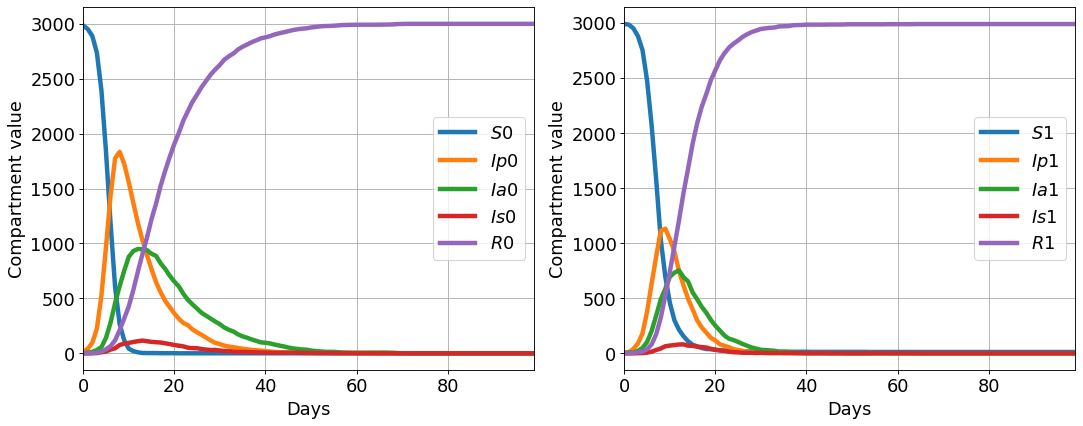

In [34]:
# Plot the data: separate nodes
fig = plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 16})
if N_nodes == 1:
    ax1 = fig.subplots(1,1)
else:
    ax1, ax2 = fig.subplots(1,2)

ax1.plot(t, S0, '-',  label='$S0$', lw=4)
ax1.plot(t, Ip0, '-', label='$Ip0$', lw=4)
ax1.plot(t, Ia0, '-', label='$Ia0$', lw=4)
ax1.plot(t, Is0, '-', label='$Is0$', lw=4)
ax1.plot(t, R0, '-',  label='$R0$', lw=4)
ax1.legend()
ax1.grid()
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('Compartment value')
ax1.set_xlabel('Days')
if N_nodes > 1:
    ax2.plot(t, S1, '-',  label='$S1$', lw=4)
    ax2.plot(t, Ip1, '-', label='$Ip1$', lw=4)
    ax2.plot(t, Ia1, '-', label='$Ia1$', lw=4)
    ax2.plot(t, Is1, '-', label='$Is1$', lw=4)
    ax2.plot(t, R1, '-',  label='$R1$', lw=4)
    ax2.legend()
    ax2.grid()
    ax2.autoscale(enable=True, axis='x', tight=True)
    ax2.set_ylabel('Compartment value')
    ax2.set_xlabel('Days')

## Inference from synthetic data of two nodes

Let's infere using the first 60 days.

In [35]:
Tf_inference = 60
Nf_inference = Tf_inference + 1

# initialise the estimator 
estimator = pyross.inference.Model(model_spec_metapop, parameters, M, N_age, steps=4, time_dep_param_mapping=parameter_mapping)

In [36]:
# active cases
fltr = np.kron([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],np.identity(M)) # note order of variables in model data
obs=np.einsum('ij,kj->ki', fltr, x[N_start:N_start+Nf_inference]) # DON'T LET obs BE LONGER THAN THE INFERENCE INTERVAL
print(estimator.class_index_dict.keys())
print(fltr)
print(obs.shape)

dict_keys(['S0', 'Ip0', 'Ia0', 'Is0', 'R0', 'S1', 'Ip1', 'Ia1', 'Is1', 'R1'])
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
(61, 6)


In [37]:
# compute -log_p for the original (correct) parameters 
start_time = time.time()
x0 = x[0]
#x0 = obs[0]

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix, tangent=False)

end_time = time.time()
print(logp)
print(end_time - start_time)

954.4378165807955
0.1291031837463379


#### Priors

In [39]:
# make parameter guesses and set up bounds for each parameter
eps=1e-4
alpha_g, gIp0_g, gIp1_g, beta00_g, beta01_g, beta10_g, beta11_g = parameters.values()

# Set up priors
eps = 1e-4
param_priors = {
    'gIp0':{
        'mean': gIp0_g,
        'std': 0.1*gIp0_g,
        'bounds': [0.5*gIp0_g, 2*gIp0_g],
        'prior_fun': 'truncnorm'
    },
    'gIp1':{
        'mean': gIp1_g,
        'std': 0.1*gIp1_g,
        'bounds': [0.5*gIp1_g, 2*gIp1_g],
        'prior_fun': 'truncnorm'
    },
    'beta00':{
        'mean': beta00_g,
        'std': 0.1*beta00_g,
        'bounds': [0.5*beta00_g, 2*beta00_g],
        'prior_fun': 'truncnorm'
    },
    'beta01':{
        'mean': beta01_g,
        'std': 0.1*beta01_g,
        'bounds': [0.5*beta01_g, 2*beta01_g],
        'prior_fun': 'truncnorm'
    },
    'beta10':{
        'mean': beta10_g,
        'std': 0.1*beta10_g,
        'bounds': [0.5*beta10_g, 2*beta10_g],
        'prior_fun': 'truncnorm'
    },
    'beta11':{
        'mean': beta11_g,
        'std': 0.1*beta11_g,
        'bounds': [0.5*beta11_g, 2*beta11_g],
        'prior_fun': 'truncnorm'
    }
}



# make initial value guesses and set up bounds for each initial value
# S_bounds = [980, 1000]
S_bounds = [4000, 8000]
I_bounds = [eps, 20]
#init_fltr = [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False]
# init_fltr = np.tile(np.repeat([True, True, False], M), N_nodes)
#init_fltr = np.tile(np.repeat([True, False, True], M), N_nodes)
# init_fltr = np.tile(np.repeat([False, True, False], M), N_nodes)
#init_fltr = np.repeat([True, True, True, False, True, True, True, True, False, True], M) # AT LEAST ONE OF THE OBSERVED MUST BE SET TO FALSE (should all of them be False?)
#init_fltr = np.repeat([True, True, False, False, True, True, True, False, False, True], M) # AT LEAST ONE OF THE OBSERVED MUST BE SET TO FALSE (should all of them be False?)
init_fltr = np.repeat([True, False, False, False, True, True, False, False, False, True], M) # AT LEAST ONE OF THE OBSERVED MUST BE SET TO FALSE (should all of them be False?)
#init_fltr = np.repeat([True, False, True, False, True, True, True, True, True, True], M) # AT LEAST ONE OF THE OBSERVED MUST BE SET TO FALSE (should all of them be False?)
#init_fltr = np.repeat([True, True, False, False, True, True, True, True, True, True], M) # AT LEAST ONE OF THE OBSERVED MUST BE SET TO FALSE (should all of them be False?)
init_priors = {
    'independent':{
        'fltr': init_fltr,
        # 'mean': np.tile(np.repeat([990.0, 10.0], M), N_nodes), #[990.0, 990.0, 10.0, 10.0], 
#        'mean': np.tile(np.repeat([4488.0, 10.0], M), N_nodes), #[990.0, 990.0, 10.0, 10.0], 
#        'std': np.tile(np.repeat([10.0, 1.0], M), N_nodes), #[1.0, 1.0, 1.0, 1.0], 
#        'bounds': [[980, 1000],[980, 1000],[ 0, 20],[0, 20],[980, 1000],[980, 1000],[0, 20],[0, 20],[980, 1000],[980, 1000],[0, 20],[0, 20]]
#        'bounds': np.tile(np.repeat([S_bounds, I_bounds], M, axis=0), (N_nodes,1))#[[980, 1000], [980, 1000], [0, 20], [0, 20]]
#        'mean': [990, 990, 10, eps, eps, eps, 990, 990, eps, eps, eps, eps, 990, 990, eps, eps], #[990.0, 990.0, 10.0, 10.0], # MUST NOT BE ZERO
#        'std': [10, 10, 1, 1, 1, 1, 10, 10, 1, 1, 1, 1, 10, 10, 1, 1], #[1.0, 1.0, 1.0, 1.0],
#        'bounds': [[980, 1000],[980, 1000],[0, 20],[0, 20],[0, 10],[0, 10],[980, 1000],[980, 1000],[0, 20],[0, 20],[ 0, 10],[0, 10],[980, 1000],[980, 1000],[0, 20],[0, 20]]
#        'mean': [3000, 15, eps, eps, 3000, eps, eps, eps],
#        'std': [100, 1, 1, 1, 100, 1, 1, 1],
#        'bounds': [[2800, 3000], [10, 20], [0, 2], [0, 2], [2800, 3000], [0, 2], [0, 2], [0, 2]]
        'mean': [3100, eps, 3100, eps],
        'std': [100, 1, 100, 1],
        'bounds': [[2985, 3200], [0, 2], [2990, 3200], [0, 2]]
#        'mean': [2800, eps, eps, 2800, eps, eps, eps, eps],
#        'std': [200, 1, 1, 200, 1, 1, 1, 1],
#        'bounds': [[2600, 3000], [0, 2], [0, 2], [2600, 3000], [0, 2], [0, 2], [0, 2], [0, 2]]
#        'mean': [2800, 10, eps, 2800, eps, eps, eps, eps],
#        'std': [200, 2, 1, 200, 1, 1, 1, 1],
#        'bounds': [[2500, 3000], [0, 20], [0, 2], [2500, 3000], [0, 2], [0, 2], [0, 2], [0, 2]]
    }
}

print(estimator.class_index_dict.keys())
print(init_priors)

dict_keys(['S0', 'Ip0', 'Ia0', 'Is0', 'R0', 'S1', 'Ip1', 'Ia1', 'Is1', 'R1'])
{'independent': {'fltr': array([ True, False, False, False,  True,  True, False, False, False,
        True]), 'mean': [3100, 0.0001, 3100, 0.0001], 'std': [100, 1, 100, 1], 'bounds': [[2985, 3200], [0, 2], [2990, 3200], [0, 2]]}}


#### Actual fitting

In [40]:
# optimisation parameters 
ftol = 1e-8 # the relative tol in (-logp)  

estimator.set_det_method('RK45')
estimator.set_lyapunov_method('euler') # use faster methods 
start_time = time.time()
res = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,
                                            tangent=False, global_max_iter=100, global_atol=0.1, 
                                           cma_processes=4, verbose=True, ftol=ftol,
                                            local_max_iter=100)
end_time = time.time()
print(end_time - start_time)

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=459685286, Fri Oct 28 15:13:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 5.876145670490491e+37 1.0e+00 9.29e-01  5e-03  7e+01 0:00.6
    2     32 4.904012938005209e+37 1.2e+00 9.91e-01  5e-03  8e+01 0:01.1
    3     48 4.021491314729166e+37 1.5e+00 1.18e+00  6e-03  9e+01 0:02.0
    9    144 4.018449133452196e+37 1.6e+00 1.33e+00  7e-03  8e+01 0:05.4
   16    256 4.016263456779656e+37 2.4e+00 1.23e+00  6e-03  5e+01 0:09.7
   24    384 4.036587936704000e+37 4.9e+00 1.25e+00  6e-03  3e+01 0:14.9
   33    528 4.005524169842905e+37 7.4e+00 7.90e-01  4e-03  1e+01 0:21.0
   45    720 4.003664367578133e+37 1.1e+01 3.62e-01  2e-03  4e+00 0:28.3
   59    944 4.002393116082934e+37 1.7e+01 1.68e-01  9e-04  1e+00 0:36.4
   72   1152 4.002214279219132e+37 2.8e+01 8.80e-02  5e-04  5e-01 0:45.7
   89   1424 4.002210882938002e+37 6.1e+01 5.57e-02  3e-04  2e-01 0:56

In [41]:
# print the correct params and best estimates 
print('True parameters')
#parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = res['params_dict'].copy()
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print((x[0]).astype('int'))


map_x0 = res['x0'].copy()
print('\n Inferred initial conditions: ') 
print(map_x0.astype('int'))

logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_inference, contactMatrix)

print('\n log p for best estimates:')
print(logp)

True parameters
{'alpha': 0.9, 'gIp0': 0.15, 'gIp1': 0.3, 'beta00': 0.9, 'beta01': 0.1, 'beta10': 0.05, 'beta11': 0.6}

 Best estimates
{'alpha': 0.9, 'gIp0': 0.13883426822121528, 'gIp1': 0.35693307419973197, 'beta00': 1.24750530908898, 'beta01': 0.14262591438844555, 'beta10': 0.043823150495515814, 'beta11': 0.3612557815733568}

 True initial conditions: 
[2985   15    0    0    0 2990   10    0    0    0]

 Inferred initial conditions: 
[2985   15    0    0    0 2990   10    0    0    0]

 log p for best estimates:
1655.6123131408572


#### Plot

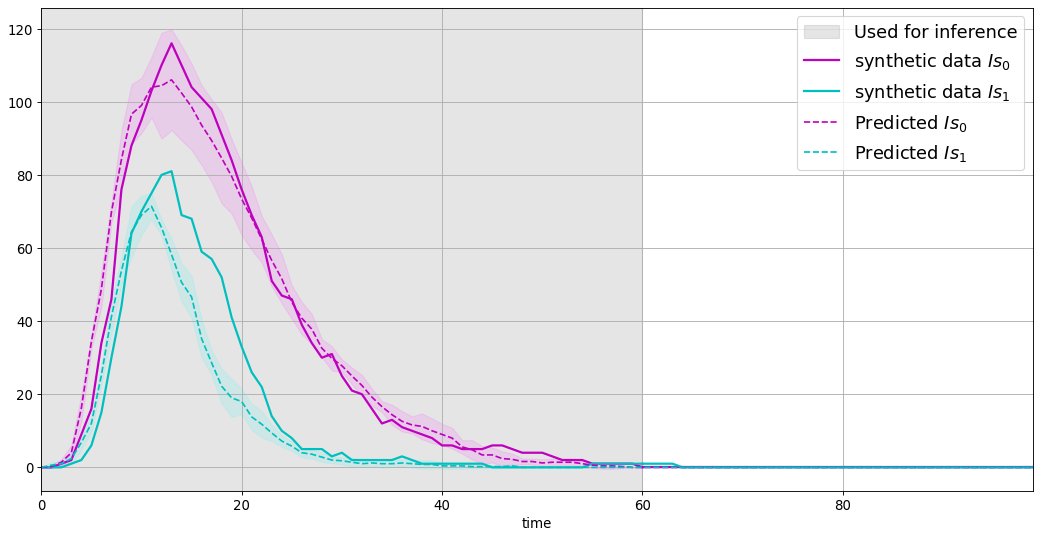

In [42]:
fig1 = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
ax1 = fig1.subplots(1,1)

x_start = map_x0
t = data['t']

SHOW_GROUND_TRUTH = True

ax1.axvspan(N_start, Tf_inference+N_start, label='Used for inference', alpha=0.2, color='grey')
ax1.plot(t[:N_start+Tf_inference+1], Is0[:N_start+Tf_inference+1], 'm-', label='synthetic data $Is_0$', lw=2)
ax1.plot(t[:N_start+Tf_inference+1], Is1[:N_start+Tf_inference+1], 'c-', label='synthetic data $Is_1$', lw=2)

if SHOW_GROUND_TRUTH:
    ax1.plot(t[N_start+Tf_inference:], Is0[N_start+Tf_inference:], 'm-', lw=2)
    ax1.plot(t[N_start+Tf_inference:], Is1[N_start+Tf_inference:], 'c-', lw=2)

# show stochastic variability
N_runs = 5
Is0_fit = np.zeros([N_runs,Nf],dtype=float)
Is1_fit = np.zeros([N_runs,Nf],dtype=float)

model_fit = pyross.stochastic.Model(model_spec_metapop, best_estimates, M, N_age, time_dep_param_mapping=parameter_mapping)

for loop in range(0,N_runs):
    data_fit = model_fit.simulate(x_start, contactMatrix, Tf, Nf)
    Is0_fit[loop] = np.sum(model_fit.model_class_data('Is0',data_fit), axis=1)
    Is1_fit[loop] = np.sum(model_fit.model_class_data('Is1',data_fit), axis=1)

Is0_fit_mean = np.mean(Is0_fit,axis=0)
Is1_fit_mean = np.mean(Is1_fit,axis=0)
Is0_fit_std = np.std(Is0_fit,axis=0)
Is1_fit_std = np.std(Is1_fit,axis=0)

plt.plot(t, Is0_fit_mean, 'm--',label='Predicted $Is_0$')
plt.fill_between(t,Is0_fit_mean-Is0_fit_std,Is0_fit_mean+Is0_fit_std,color='magenta', alpha=0.1)

plt.plot(t, Is1_fit_mean, 'c--',label='Predicted $Is_1$')
plt.fill_between(t,Is1_fit_mean-Is1_fit_std,Is1_fit_mean+Is1_fit_std,color='cyan', alpha=0.1)

plt.legend(fontsize=16)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)